![Сбор данных](https://ptzgovorit.ru/sites/default/files/original_nodes/banka_tasima_7.jpg)

# Содержание

- [1. Библиотеки](#1.-Библиотеки)
- [2. Загрузка и предобработка временного ряда](#2.-Загрузка-и-предобработка-временного-ряда)
- [3. Визуальный анализ ряда](#3.-Визуальный-анализ-ряда)
- [3. Декомпозиция и анализ Фурье](#3.-Декомпозиция-и-анализ-Фурье)

# 1. Библиотеки

In [1]:
%matplotlib inline

#базовые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import datetime

#библиотеки для анаоиза временного ряда остатков на счетах клиентов:
#декомпозиция, фурье, тест на стационарность
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
import statsmodels.api as sm # отсюда будем брать тест Дикки-Фуллера

#для отладки кода (в случае необходимости)
import pdb

# 2. Загрузка и предобработка временного ряда

In [2]:
sb = pd.read_csv('C:/Users/Алексей Третьяков/Desktop/ML_projects/FierceDra-X.github.io/Sber/data.csv', sep = ';')
sb.info(), sb.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   REPORTDATE  2111 non-null   object
 1   VALUE       2111 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.1+ KB


(None,
 REPORTDATE    0
 VALUE         0
 dtype: int64)

In [3]:
sb.sample(5)

,REPORTDATE,VALUE
1367,27.09.2017,37316901135
1578,26.04.2018,37266501108
1740,05.10.2018,53600450319
2070,31.08.2019,61158180425
301,27.10.2014,16175563049


В ряде нет нулевых значений; значения дат находятся в строковом формате; value имеют визуально неудобную длину;

Переименуем столбцы в более удобные значения date и value; переменную date переведем в формат datetime; value разделим на 10 в шестой степени и округлим до одного знака

In [4]:
new_columns = ['date', 'value']
sb.columns = new_columns

sb['date'] = pd.to_datetime(sb['date'], format = '%d.%m.%Y')
sb['value'] = np.round(sb.value.values/10**6, 1)

In [6]:
sb.tail(5)

,date,value
2106,2019-10-06,64630.1
2107,2019-10-07,66115.3
2108,2019-10-08,68424.0
2109,2019-10-09,72492.9
2110,2019-10-10,72307.9


# 3. Визуальный анализ ряда

в этом разделе визуально посмотрим на ряд с целью первичного выявления его характеристик

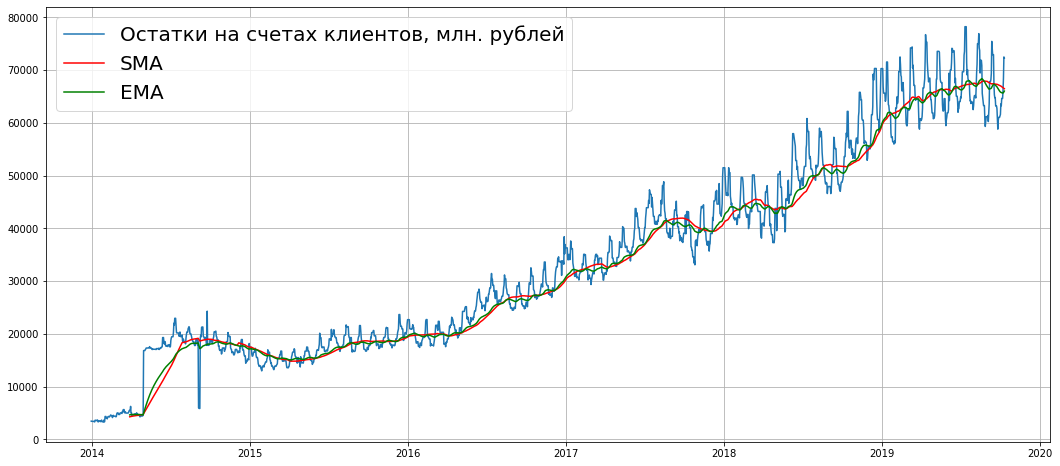

In [7]:
## визуализируем ряд вместе со скользящими средними (обычное и экспоненциальное) ряда с окном в 3 месяца
N=90
sb['rolling_min_sma'] = sb.value.rolling(window=N).mean()
sb['rolling_min_ema'] = sb.value.ewm(min_periods=N, span=N).mean()


f, ax = plt.subplots(1, 1, figsize=(18, 8))

ax.plot(sb.date, sb.value)
ax.plot(sb.date, sb.rolling_min_sma, c='r')
ax.plot(sb.date, sb.rolling_min_ema, c='g')
ax.legend(['Остатки на счетах клиентов, млн. рублей', 'SMA', 'EMA'], fontsize=20)
ax.grid()

> * ряд имеет явный тренд роста с  середины 2015 года и, скорее всего, его первые разницы на тренде стационарны
> * еще видны регулярные колебание, посмотрим на них в более коротких отрезках времени

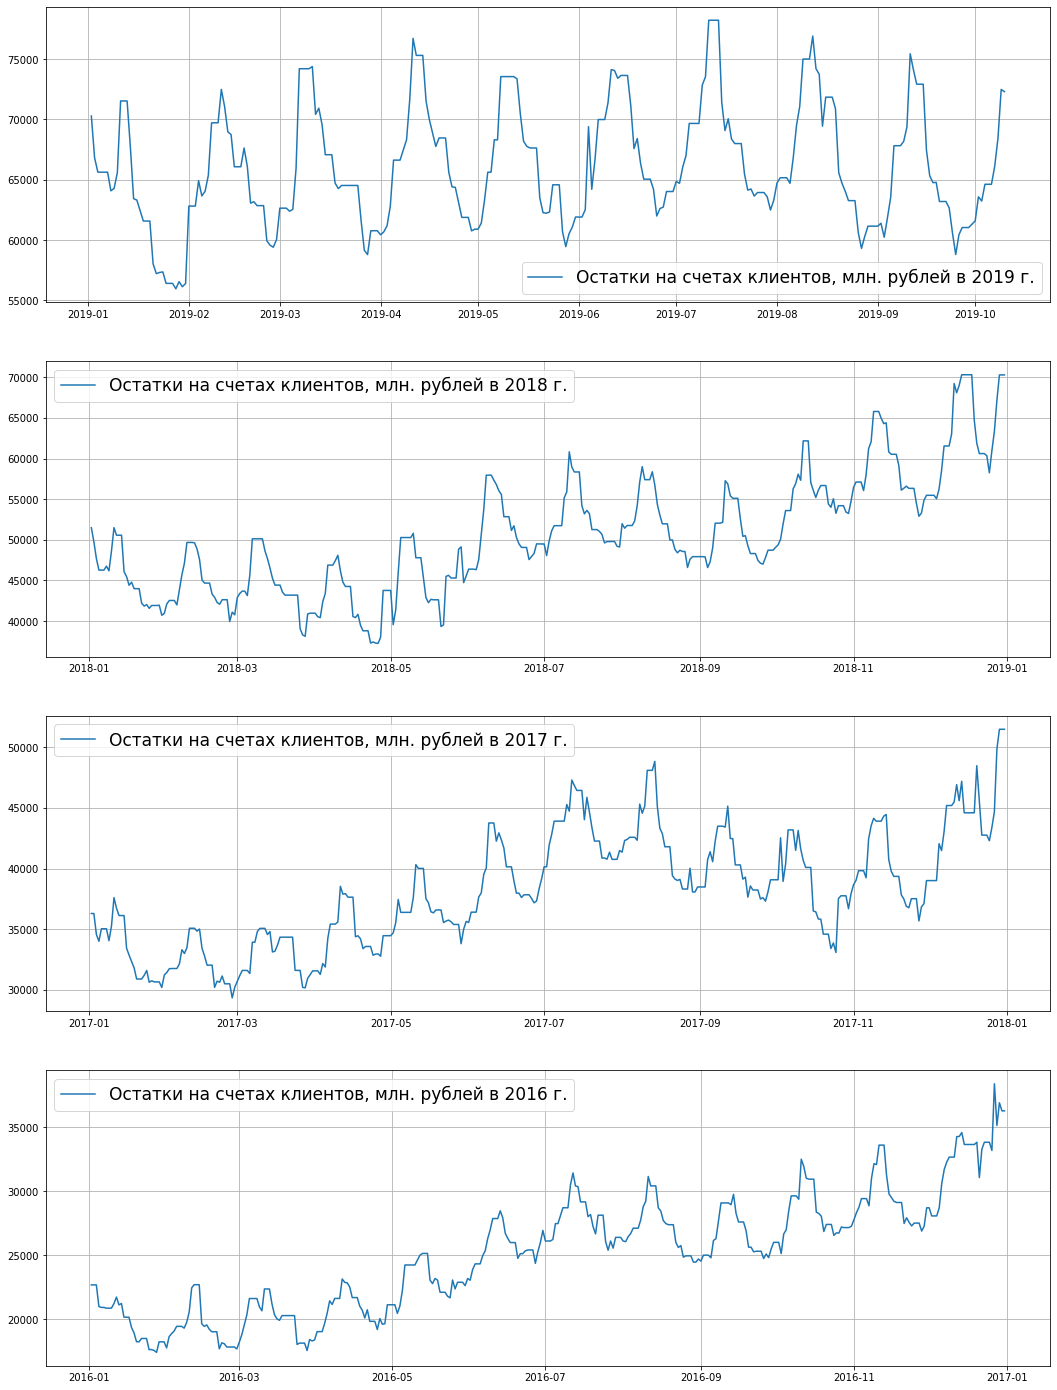

In [8]:
f, ax = plt.subplots(4, 1, figsize=(18, 25))

ax[0].plot(sb[sb.date > '2019-01-01'].date, sb[sb.date > '2019-01-01'].value) 
ax[0].legend(['Остатки на счетах клиентов, млн. рублей в 2019 г.'], fontsize=17)
ax[0].grid()

ax[1].plot(sb[(sb.date > '2018-01-01') & (sb.date < '2019-01-01')].date,
           sb[(sb.date > '2018-01-01') & (sb.date < '2019-01-01')].value) 
ax[1].legend(['Остатки на счетах клиентов, млн. рублей в 2018 г.'], fontsize=17)
ax[1].grid()

ax[2].plot(sb[(sb.date > '2017-01-01') & (sb.date < '2018-01-01')].date,
           sb[(sb.date > '2017-01-01') & (sb.date < '2018-01-01')].value) 
ax[2].legend(['Остатки на счетах клиентов, млн. рублей в 2017 г.'], fontsize=17)
ax[2].grid()

ax[3].plot(sb[(sb.date > '2016-01-01') & (sb.date < '2017-01-01')].date,
           sb[(sb.date > '2016-01-01') & (sb.date < '2017-01-01')].value) 
ax[3].legend(['Остатки на счетах клиентов, млн. рублей в 2016 г.'], fontsize=17)
ax[3].grid()

> * остатки явно испытывают месячные колебания
> * минимумы приходятся на конец месяца, максимумы на район 10-ого числа месяца
> * скорее всего, это влияние цикличности в выплатах заработной платы
> * также видно, что остатки не росли в первые 5 месяцев в 2016-2018 годах, рост начинался примерно после мая

# 3. Декомпозиция и анализ Фурье

In [9]:
# разложим ряд на трендовую, сезонную и шумовую составляющие
sb_decomp = sb.set_index(pd.DatetimeIndex(sb['date']))
sb_decomp.drop(['date','rolling_min_sma','rolling_min_ema'], axis = 1, inplace=True)

decomposition = seasonal_decompose(sb_decomp, model='additive') 
trend_part = decomposition.trend # отдельно трендовая составляющаяя
seasonal_part = decomposition.seasonal # отдельно сезонная составляющаяя
residual_part = decomposition.resid # отдельно шум: то, что осталось

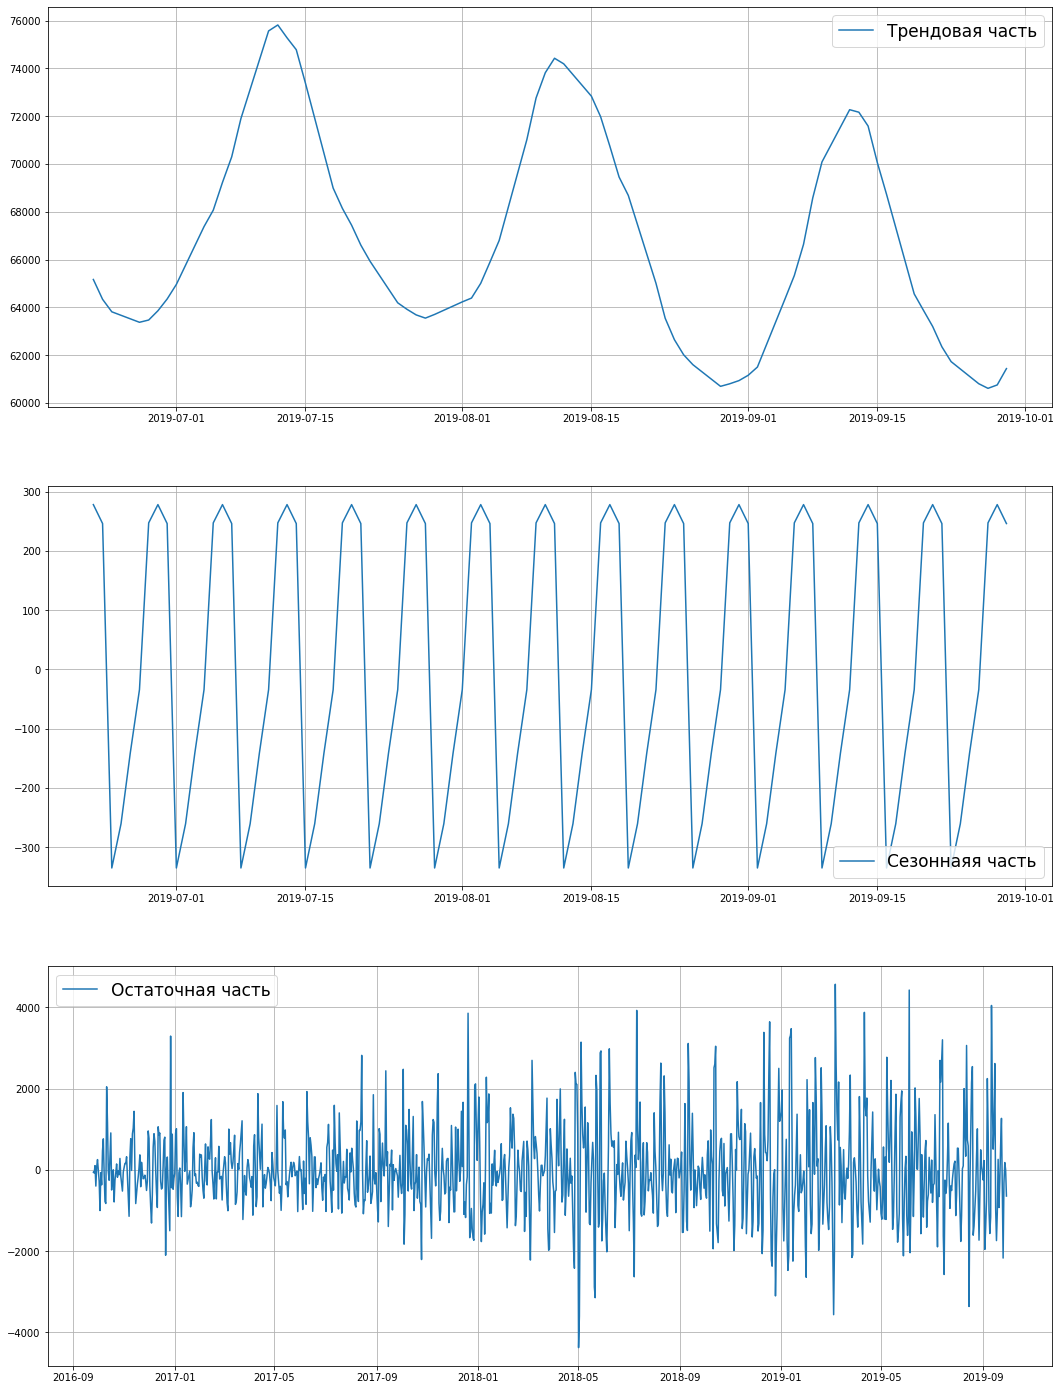

In [10]:
## визуализируем
f, ax = plt.subplots(3, 1, figsize=(18, 25))

ax[0].plot(trend_part[2000:2100]) 
ax[0].legend(['Трендовая часть'], fontsize=17)
ax[0].grid()

ax[1].plot(seasonal_part[2000:2100]) 
ax[1].legend(['Сезоннаяя часть'], fontsize=17)
ax[1].grid()

ax[2].plot(residual_part[1000:2100]) 
ax[2].legend(['Остаточная часть'], fontsize=17)
ax[2].grid()

> * сезонная часть есть, но она незначительна в амплитуде
> * ряд в основном состоит из тредовой и остаточной случайной части с амплитудами колебаний в несколько млрд.

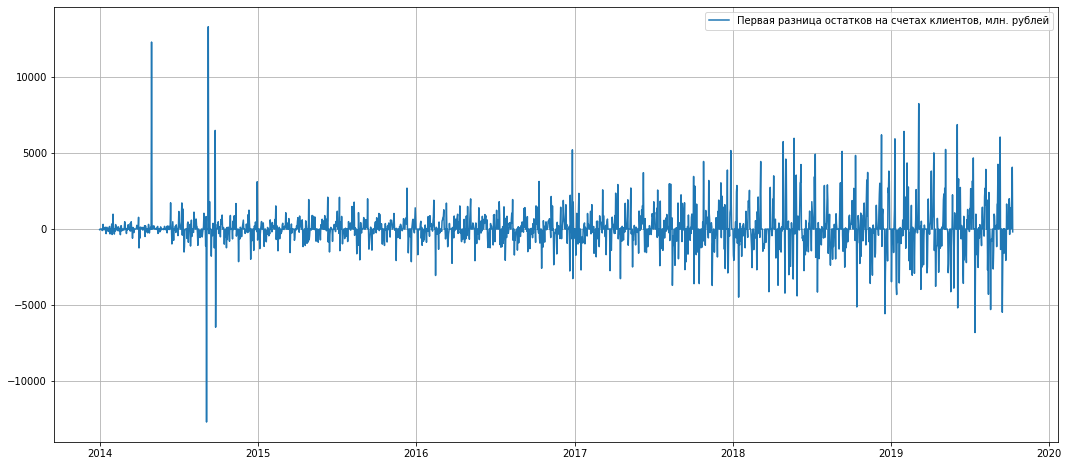

In [11]:
#проверим первые разности ряда на стационарность
sb['res'] =  sb.value - sb.value.shift(1)

f, ax = plt.subplots(1, 1, figsize=(18, 8))

ax.plot(sb.date, sb.res)
ax.legend(['Первая разница остатков на счетах клиентов, млн. рублей'])
ax.grid()

In [12]:
# Проверим стационарность тестом Дикки-Фуллера
test = sm.tsa.adfuller(sb['res'][1:].values)
p_value = test[1]
print ('p-value: ', p_value)
if p_value> 0.05: 
    print (' ряд не стационарен')
else:
    print ('ряд стационарен')

p-value:  0.0
ряд стационарен


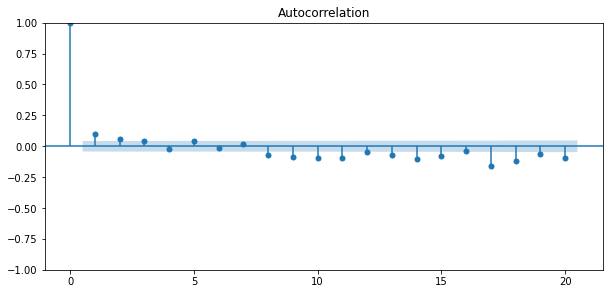

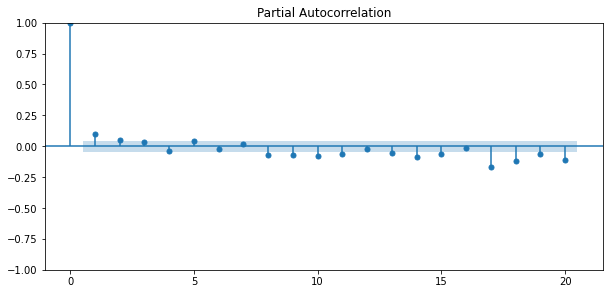

In [13]:
f, ax = plt.subplots(figsize=(10, 10))
ax = plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(sb.res.values[1:].squeeze(), lags=20, ax=ax)
plt.show()

f, ax = plt.subplots(figsize=(10, 10))
ax = plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(sb.res.values[1:].squeeze(), lags=20, method = 'ywm', ax=ax)
plt.show()

Посмотрим на фурье распределение ряда value

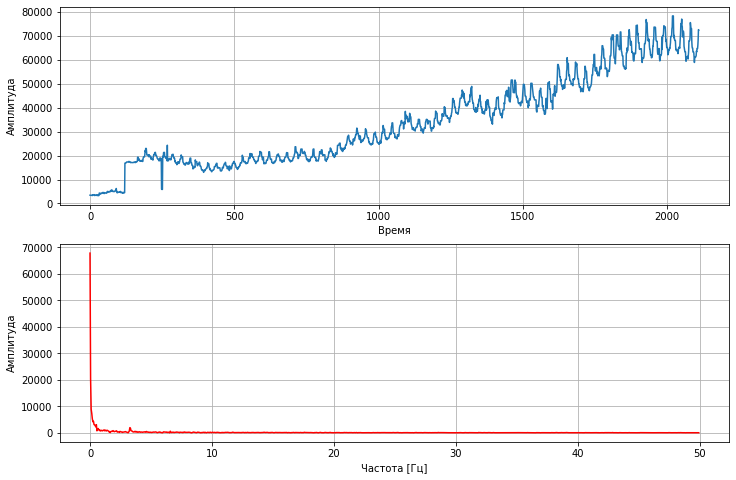

In [14]:
Fs = 100## частота дискретизации: 100 Гц
Ts = 1/Fs ## интервал времени между соседними точками

N = len(sb.value.values)
## создаём сетку частот
frq = np.fft.fftfreq(N, Ts)
## нас интересуют только положительные частоты (отрицательные частоты симметричны) 
frq = frq[range(int(N/2))]

## делаем преобразование Фурье
Y = 2/N * np.fft.fft(sb.value.values)
## нас интересуют только положительные частоты (отрицательные частоты симметричны) 
Y = Y[range(int(N/2))]

## визуализируем
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(sb.value.values)
ax[0].set_xlabel('Время')
ax[0].set_ylabel('Амплитуда')
ax[0].grid()

ax[1].plot(frq, abs(Y), 'r') 
ax[1].set_xlabel('Частота [Гц]')
ax[1].set_ylabel('Амплитуда')
ax[1].grid()

In [15]:
## создаём фильтр Баттерворта
b, a = signal.butter(8, 0.1)
## применяем его
value_filt = signal.filtfilt(b, a, sb.value, padlen=150)

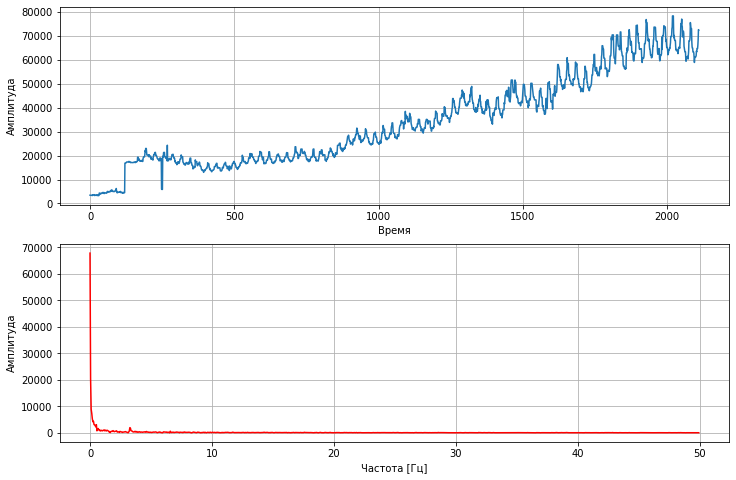

In [16]:
Fs = 100## частота дискретизации: 100 Гц
Ts = 1/Fs ## интервал времени между соседними точками

N = len(sb.value.values)
## создаём сетку частот
frq = np.fft.fftfreq(N, Ts)
## нас интересуют только положительные частоты (отрицательные частоты симметричны) 
frq = frq[range(int(N/2))]

## делаем преобразование Фурье
Y = 2/N * np.fft.fft(sb.value.values)
## нас интересуют только положительные частоты (отрицательные частоты симметричны) 
Y = Y[range(int(N/2))]

## визуализируем
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(sb.value.values)
ax[0].set_xlabel('Время')
ax[0].set_ylabel('Амплитуда')
ax[0].grid()

ax[1].plot(frq, abs(Y), 'r') 
ax[1].set_xlabel('Частота [Гц]')
ax[1].set_ylabel('Амплитуда')
ax[1].grid()

In [17]:
sb['value_filt'] = value_filt
sb.drop(['rolling_min_sma','rolling_min_ema'], axis=1, inplace=True)
sb

,date,value,res,value_filt
0,2013-12-30,3457.6,NaN,3457.612614
1,2013-12-31,3417.1,-40.5,3451.526706
2,2014-01-01,3417.1,0.0,3446.605409
3,2014-01-02,3417.1,0.0,3443.885054
4,2014-01-03,3417.1,0.0,3444.156062
...,...,...,...,...
2106,2019-10-06,64630.1,0.0,66844.954790
2107,2019-10-07,66115.3,1485.2,68165.652170
2108,2019-10-08,68424.0,2308.7,69525.639733
2109,2019-10-09,72492.9,4068.9,70910.751777


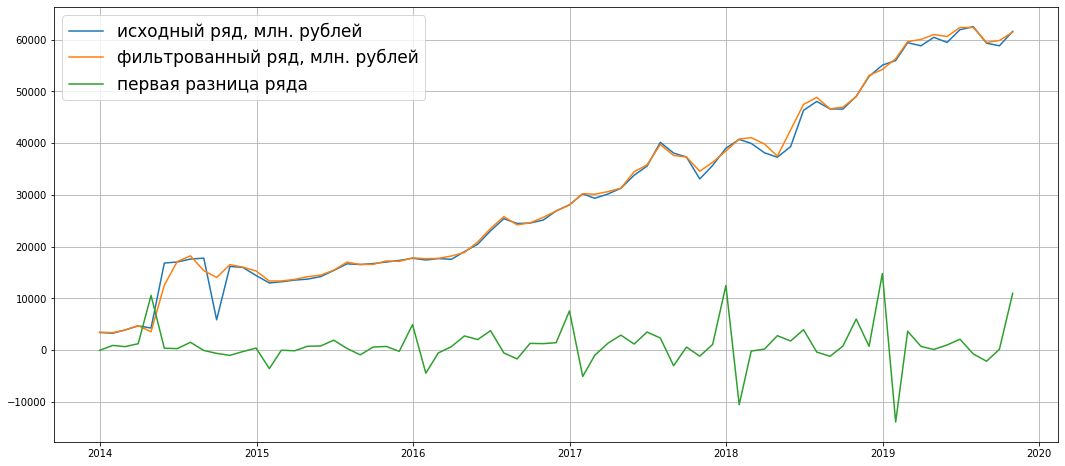

In [18]:
conversion = {'value' : 'min',
             'value_filt': 'min',
             'res': 'sum'}

sb = sb.set_index('date')
sb_resampled = sb[1:].resample('1M').apply(conversion)
sb = sb.reset_index()
sb_resampled = sb_resampled.reset_index()

f, ax = plt.subplots(1, 1, figsize=(18, 8))

ax.plot(sb_resampled.date, sb_resampled.value)
ax.plot(sb_resampled.date, sb_resampled.value_filt)
ax.plot(sb_resampled.date, sb_resampled.res)
ax.legend(['исходный ряд, млн. рублей', 'фильтрованный ряд, млн. рублей', 'первая разница ряда'], fontsize=17)
ax.grid()

In [19]:
sb_resampled.to_csv('C:/Users/Алексей Третьяков/Desktop/ML_projects/FierceDra-X.github.io/Sber/data_resampled.csv',
            sep=';',
            index=False)

In [20]:
sb.to_csv('C:/Users/Алексей Третьяков/Desktop/ML_projects/FierceDra-X.github.io/Sber/data_notsampled.csv',
            sep=';',
            index=False)